In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/combined_data/03-01-03-01-02-02-13.wav
/kaggle/input/dataset/combined_data/03-02-04-01-01-01-10.wav
/kaggle/input/dataset/combined_data/03-02-01-01-02-02-24.wav
/kaggle/input/dataset/combined_data/03-02-05-02-01-01-02.wav
/kaggle/input/dataset/combined_data/03-01-08-01-01-01-02.wav
/kaggle/input/dataset/combined_data/03-01-03-01-01-01-18.wav
/kaggle/input/dataset/combined_data/03-02-06-01-02-02-02.wav
/kaggle/input/dataset/combined_data/03-01-02-01-01-01-21.wav
/kaggle/input/dataset/combined_data/03-02-06-01-02-01-01.wav
/kaggle/input/dataset/combined_data/03-01-05-02-02-02-15.wav
/kaggle/input/dataset/combined_data/03-01-05-01-01-02-03.wav
/kaggle/input/dataset/combined_data/03-02-02-02-02-02-12.wav
/kaggle/input/dataset/combined_data/03-02-03-01-01-01-17.wav
/kaggle/input/dataset/combined_data/03-02-03-02-01-02-24.wav
/kaggle/input/dataset/combined_data/03-01-02-02-01-02-08.wav
/kaggle/input/dataset/combined_data/03-02-02-02-01-02-21.wav
/kaggle/input/dataset/co

Module import


In [3]:

import pandas as pd 
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

2025-06-25 14:39:32.893075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750862373.131980      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750862373.213313      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os

paths = []
labels = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        
        # Extract label: assumes label is the last part before the file extension
        label = filename.split('.')[-2]  # e.g., "happy.wav" → "happy"
        labels.append(label.lower())

        # Optional limit
        if len(paths) >= 2800:
            break
    if len(paths) >= 2800:
        break

print('Dataset is Loaded')


Dataset is Loaded


In [4]:
len(paths)

2452

In [5]:
paths[:5]

['/kaggle/input/dataset/combined_data/03-01-03-01-02-02-13.wav',
 '/kaggle/input/dataset/combined_data/03-02-04-01-01-01-10.wav',
 '/kaggle/input/dataset/combined_data/03-02-01-01-02-02-24.wav',
 '/kaggle/input/dataset/combined_data/03-02-05-02-01-01-02.wav',
 '/kaggle/input/dataset/combined_data/03-01-08-01-01-01-02.wav']

In [6]:
labels[:5]

['03-01-03-01-02-02-13',
 '03-02-04-01-01-01-10',
 '03-02-01-01-02-02-24',
 '03-02-05-02-01-01-02',
 '03-01-08-01-01-01-02']

In [5]:
df = pd.DataFrame()
df['audio_paths'] = paths

In [6]:
import os
import librosa

missing_files = []
corrupted_files = []

for path in df['audio_paths']:
    if not os.path.exists(path):
        missing_files.append(path)
    else:
        try:
            librosa.load(path, sr=None)
        except Exception:
            corrupted_files.append(path)

print("Missing files:", missing_files)
print("Corrupted files:", corrupted_files)


Missing files: []
Corrupted files: []


In [7]:
import os

def extract_emotion_from_path(path):
    filename = os.path.basename(path)            # "03-01-05-01-02-01-12.wav"
    parts = filename.split('-')                  # ['03', '01', '05', ...]
    emotion_code = parts[2]                      # '05'
    
    emotion_map = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }
    return emotion_map.get(emotion_code, 'unknown')

# Apply it
df['emotion'] = df['audio_paths'].apply(extract_emotion_from_path)


In [8]:
print(df['emotion'].value_counts())

emotion
happy        376
sad          376
angry        376
fearful      376
calm         376
surprised    192
disgust      192
neutral      188
Name: count, dtype: int64


<Axes: xlabel='emotion', ylabel='count'>

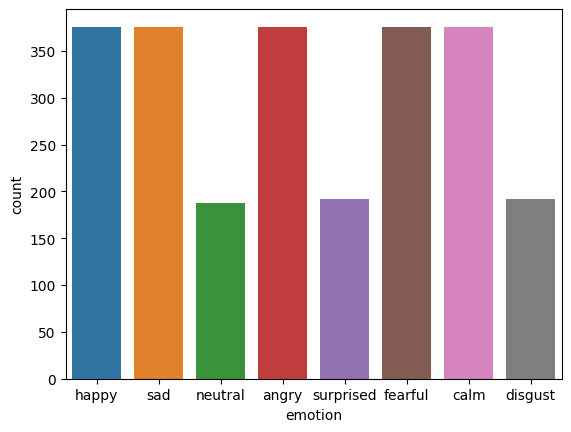

In [11]:
sns.countplot(data=df,x='emotion')

In [31]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [32]:
def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.show()

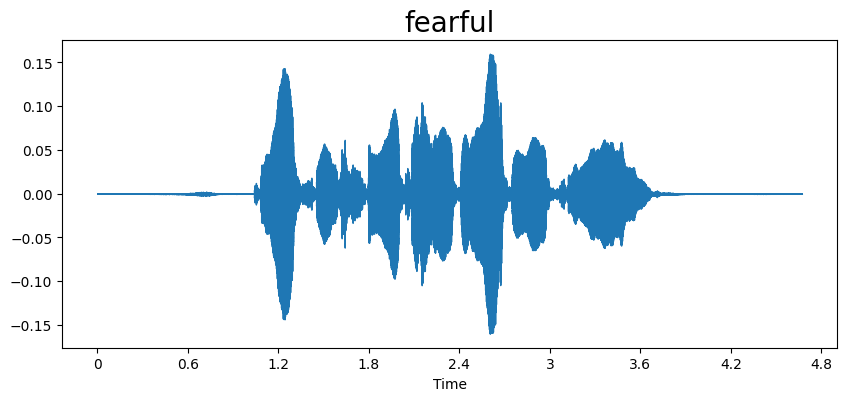

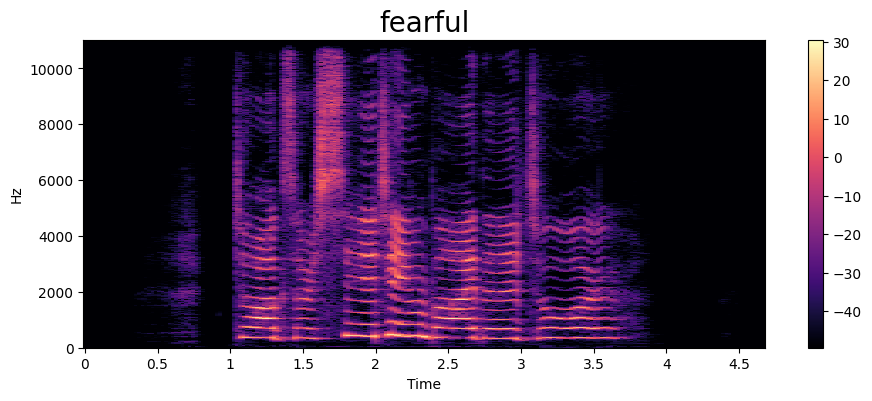

In [34]:
emotion = 'fearful'
path = np.array(df['audio_paths'][df['emotion'] == emotion])[0]

data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

Audio(path)

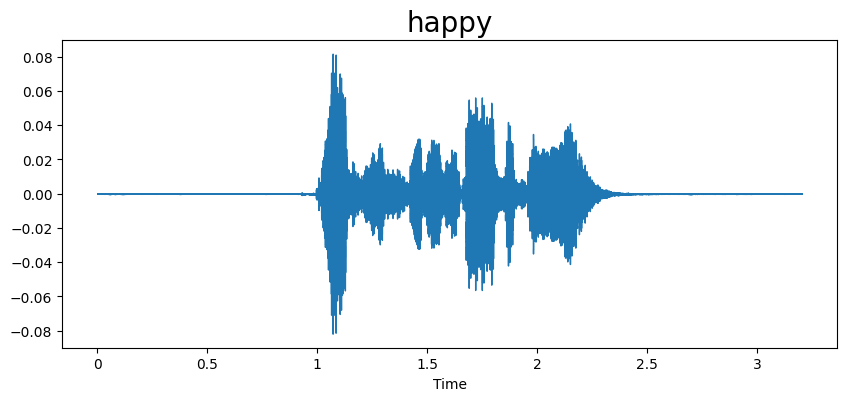

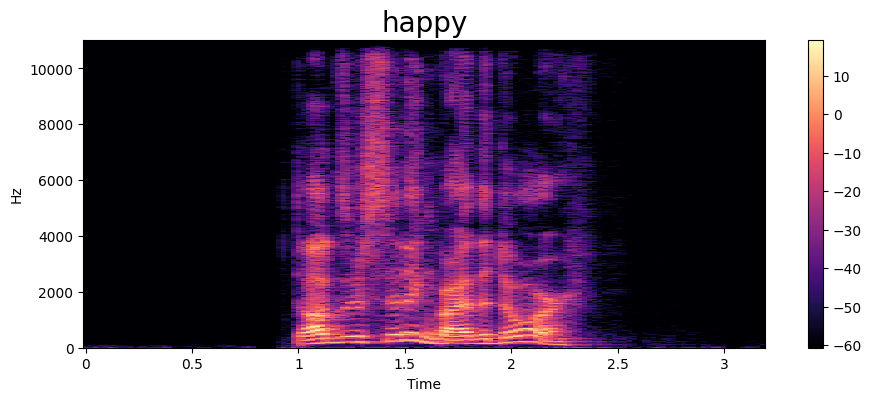

In [35]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['emotion'] == emotion])[0]

data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

Audio(path)

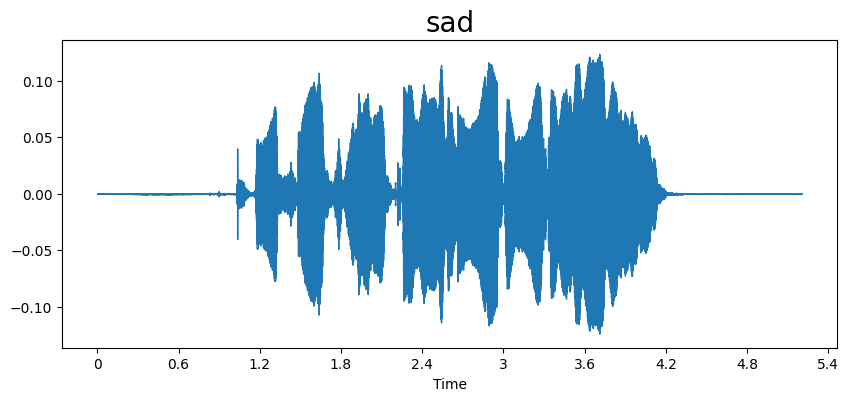

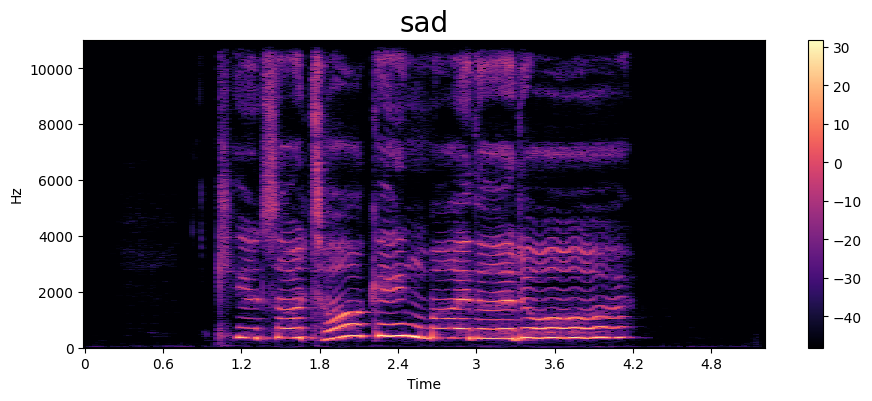

In [36]:
emotion = 'sad'
path = np.array(df['audio_paths'][df['emotion'] == emotion])[0]

data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

Audio(path)

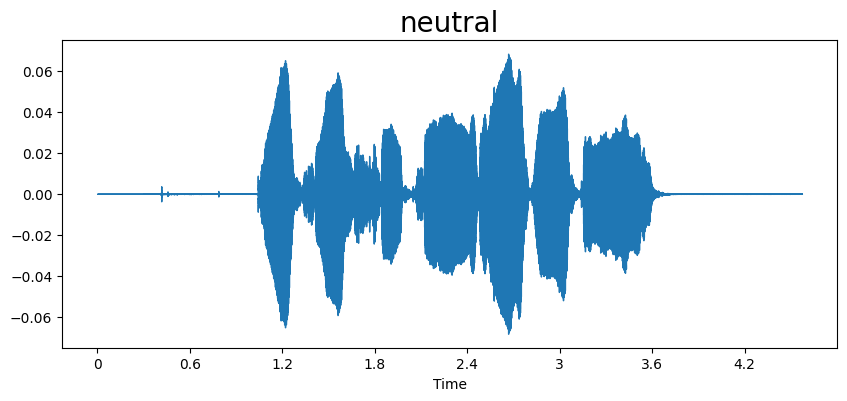

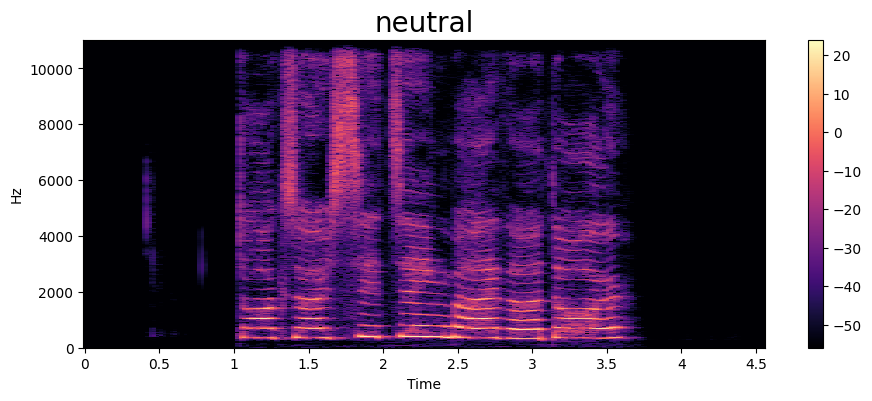

In [38]:
emotion = 'neutral'
path = np.array(df['audio_paths'][df['emotion'] == emotion])[0]

data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

Audio(path)

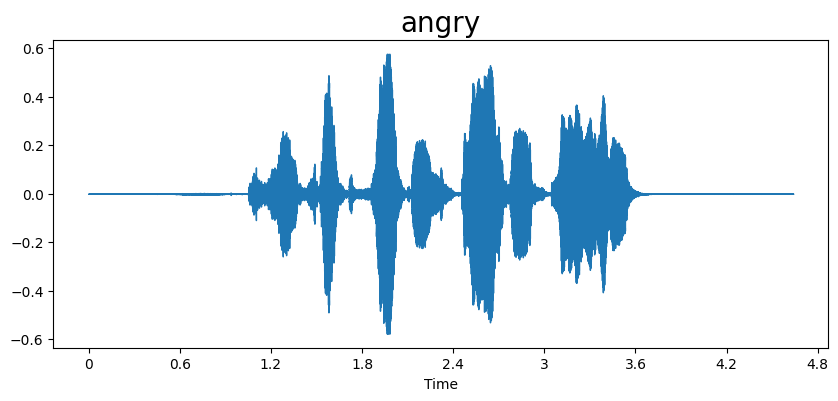

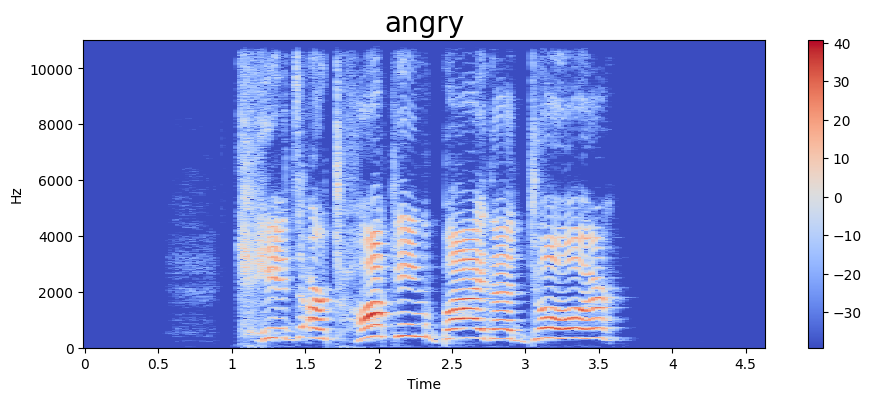

In [39]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['emotion'] == emotion])[0]

data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

Audio(path)

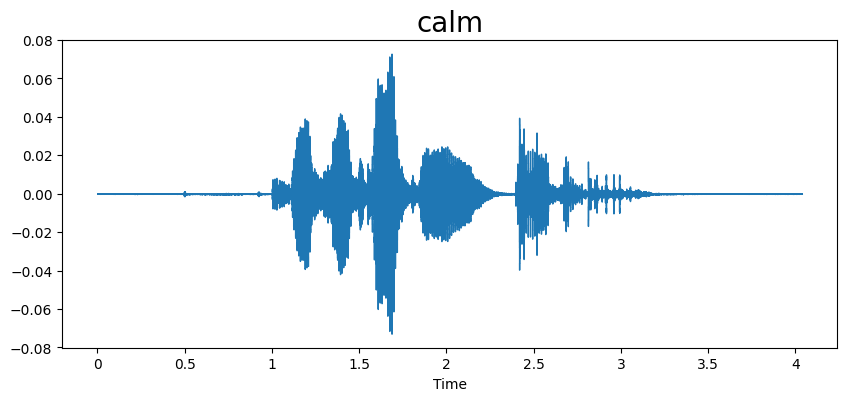

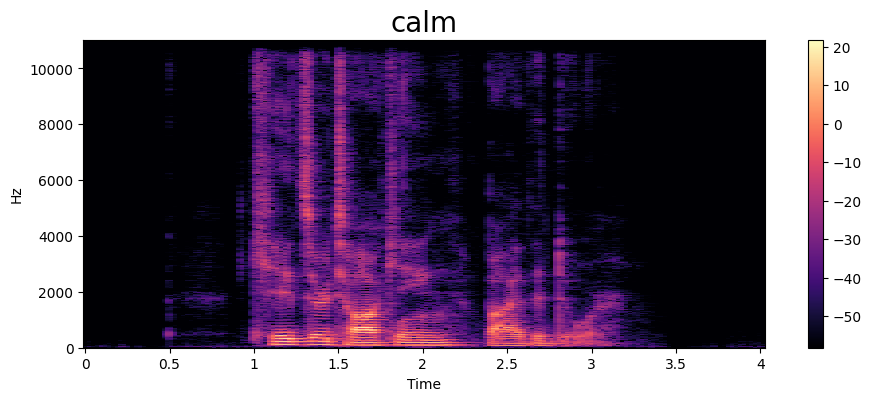

In [40]:
emotion = 'calm'
path = np.array(df['audio_paths'][df['emotion'] == emotion])[0]

data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

Audio(path)

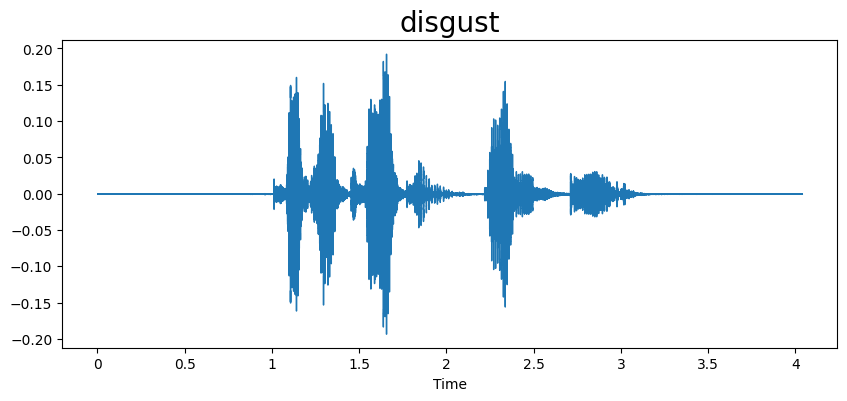

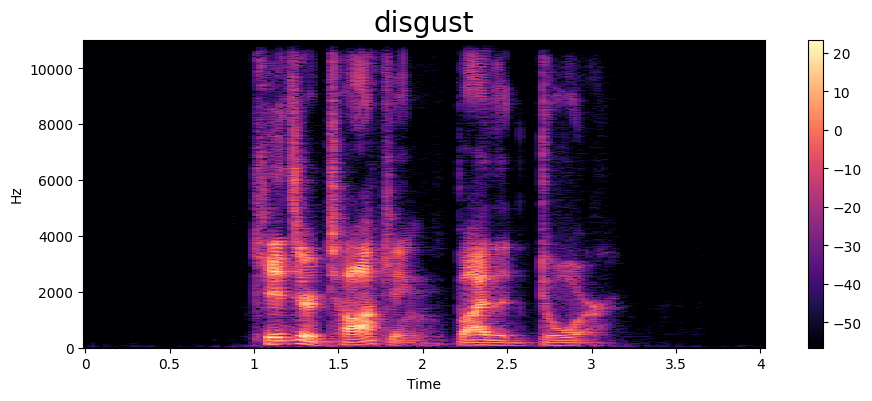

In [41]:
emotion = 'disgust'
path = np.array(df['audio_paths'][df['emotion'] == emotion])[0]

data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

Audio(path)

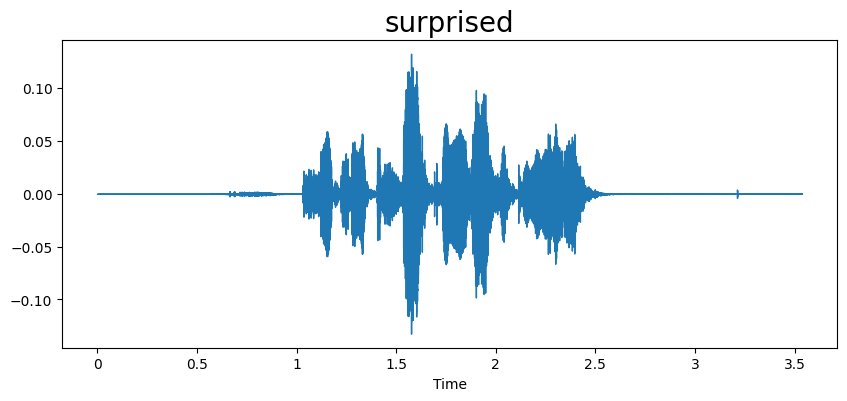

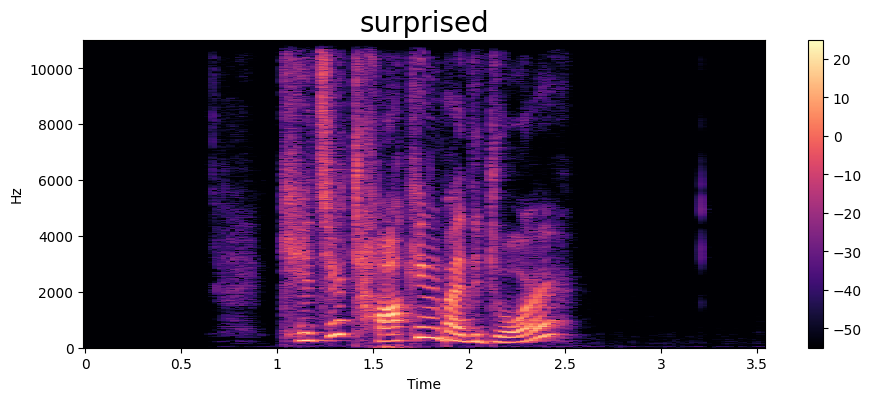

In [42]:
emotion = 'surprised'
path = np.array(df['audio_paths'][df['emotion'] == emotion])[0]

data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

Audio(path)

In [8]:
# Convert labels to integers
label_map = {label: idx for idx, label in enumerate(df['emotion'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}

# Apply the mapping
df['emotion'] = df['emotion'].map(label_map)

# View the first few rows
df.head(2)


audio_paths  emotion
0  /kaggle/input/dataset/combined_data/03-01-03-0...        0
1  /kaggle/input/dataset/combined_data/03-02-04-0...        1

In [9]:
df['labels'] = df['emotion']


In [10]:
emotion = 'fearful'  # This seems unused — possibly a mistake or placeholder

# Get the path of the first audio file where label == 2
path = np.array(df['audio_paths'][df['labels'] == 6])[0]

# Load audio file
data, sampling_rate = librosa.load(path)

# Display length of audio and duration in seconds
len(data)
sampling_rate*2


44100

In [11]:
import torch
from torch.utils.data import Dataset
import librosa
import numpy as np

class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000, sampling_rate=16000):
        self.df = df
        self.processor = processor
        self.max_length = max_length
        self.sampling_rate = sampling_rate

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get audio path and label
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['labels']

        # Load the audio file
        speech, sr = librosa.load(audio_path, sr=self.sampling_rate)

        # Pad or truncate the speech to the required length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        # Preprocess the audio file
        inputs = self.processor(
            speech,
            sampling_rate=self.sampling_rate,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=self.max_length
        )

        input_values = inputs.input_values.squeeze()

        return {
            'input_values': input_values,
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [98]:
# Split the data for train and test
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# Initialize the processor and model
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    'facebook/wav2vec2-base',
    num_labels=8  # Change this according to your number of emotion classes
)


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [100]:
sample = train_dataset[0]
print(sample)

{'input_values': tensor([-0.0006, -0.0006, -0.0010,  ..., -0.0848, -0.0684, -0.0420]), 'labels': tensor(3)}


In [101]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [22]:
pip install --upgrade transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 77.6 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
Note: you may need to restart the kernel to use updated packages.


## Set training arguments

In [84]:

training_args = TrainingArguments(
    output_dir='./results',                     
    #evaluation_strategy='epoch', 
    logging_strategy='epoch',
    logging_steps=1,
    #save_strategy='epoch',                      
    learning_rate=2e-5,                         
    per_device_train_batch_size=16,             
    per_device_eval_batch_size=16,              
    num_train_epochs=5,                         
    weight_decay=0.01,                          
    report_to=[], 
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [22]:
!pip install --upgrade --force-reinstall transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 85.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 81.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [19]:
import transformers
print(transformers.__version__)

4.51.3


In [85]:
def compute_metrics(pred):
    labels = pred.label_ids  # original labels
    preds = np.argmax(pred.predictions, axis=1)  # model predicted labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [86]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

TrainOutput(global_step=615, training_loss=0.059385856574143824, metrics={'train_runtime': 270.2598, 'train_samples_per_second': 36.28, 'train_steps_per_second': 2.276, 'total_flos': 1.7803488897792e+17, 'train_loss': 0.059385856574143824, 'epoch': 5.0})

In [88]:
model.save_pretrained('./results/trained_model')
processor.save_pretrained('./results/trained_model')

[]

In [82]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    precision_recall_fscore_support,
    classification_report
)


In [83]:
results = trainer.evaluate()
print(results)


{'eval_loss': 1.8200234174728394, 'eval_accuracy': 0.780040733197556, 'eval_precision': 0.792431823673981, 'eval_recall': 0.780040733197556, 'eval_f1': 0.7827449213297014, 'eval_runtime': 5.1929, 'eval_samples_per_second': 94.553, 'eval_steps_per_second': 5.97, 'epoch': 6.0}


In [89]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [102]:
# Sort by emotion code and assign integer labels 0-7
sorted_emotions = sorted(emotion_map.items())  # ensures order is consistent
id2label = {i: label for i, (_, label) in enumerate(sorted_emotions)}


In [103]:
# Get predictions from trainer
predictions = trainer.predict(test_dataset)

# Integer labels
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Convert to emotion names
y_true_labels = [id2label[i] for i in y_true]
y_pred_labels = [id2label[i] for i in y_pred]


In [104]:
from sklearn.metrics import classification_report

print(classification_report(y_true_labels, y_pred_labels))


              precision    recall  f1-score   support

       angry       0.69      0.74      0.72        39
        calm       0.69      0.69      0.69        75
     disgust       0.84      0.83      0.83        75
     fearful       0.89      0.77      0.83        75
       happy       0.58      0.84      0.69        38
     neutral       0.80      0.73      0.76        75
         sad       0.92      0.91      0.91        75
   surprised       0.86      0.82      0.84        39

    accuracy                           0.79       491
   macro avg       0.78      0.79      0.78       491
weighted avg       0.80      0.79      0.79       491

